# Import Python Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy

# Generate data for Regression

In the tree of depth 1 example that we looked at, the model we fit had two terminal nodes and a single feature. He're we're going to fit a model with eight terminal nodes and two features.

In [2]:
n = 2000 #Number of observations in the training set

theta = [4, 4, 10, 12]
c = [15, 40, 5, 30, 10]

x0 = np.random.uniform(0, 16, n)
x1 = np.random.uniform(0, 16, n)

x = np.array([x0,x1]).reshape((-1,2))


In [3]:
def generateY(x, splitPoints, theta, sd):
    
    
    if x[0] > theta[0]:
        if x[1] > theta[2]:
            y = np.random.normal(c[0], sd, 1)
        else:
            if x[0] <= theta[3]:
                y = np.random.normal(c[1], sd, 1) 
            else:
                y = np.random.normal(c[2], sd, 1)
    else: 
        if x[1] <= theta[1]:
            y = np.random.normal(c[3], sd, 1)
        else: 
            y = np.random.normal(c[4], sd, 1)
        
    return y[0]

y = [generateY(i, c, theta, 3) for i in x]

In [4]:
#Concatenate features and labels to create dataframe
dataFeatures = pd.DataFrame(x)
dataFeatures.columns = [f'X{i}' for i in range(2)]

dataTarget = pd.DataFrame(y)
dataTarget.columns = ['Y']

data = pd.concat([dataFeatures, dataTarget], axis = 1)


#Split up data into a training and testing set
trainTestRatio = 0.05
trainData, testData = train_test_split(data, test_size=1-trainTestRatio)

trainData.head()

,X0,X1,Y
1615,13.695913,0.961214,10.334377
1518,5.895645,9.269740,36.857414
1276,9.927904,15.067658,17.251418
1971,5.740117,0.098567,36.432726
149,3.203203,8.391481,14.792564


# Quickly plot the data so we know what it looks like

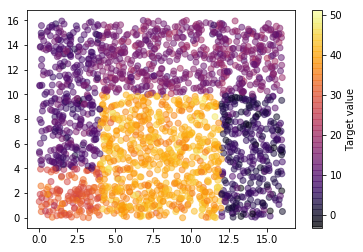

In [5]:
plt.scatter( data['X0'], data['X1'] , c=data['Y'], 
            cmap = 'inferno', alpha =0.5)
cbar = plt.colorbar()
cbar.set_label('Target value')

The relationship between the features (the x and y axis in this case) and the target (the corresponding colour of each datapoint) is fairly non-linear. 

By inspecting the dataset it's hopefully quite clear that a standard linear regression (without feature engineering) would struggle to model this dataset with a high degree of accuracy, and that a single split point (i.e. the previous decision tree example) won't be enough either. 



To model this dataset, we're going to require a decision tree with depth > 1

(**Disclaimer**: as far as I'm aware this dataset is not representative of any real-world data generation process, I constructed it specifically to show an example where Decision Trees would perform well!)

# Fitting the Decision Tree

Our solution is going to look slightly different here than it has for the earlier methods we might have seen, where the whole process (fitting, prediction etc.) was contained entirely within a class. 

We're still going to define a class, but this time our class will be a representation of a node in a tree. Two of the attributes of the node class will be node.left and node.right - node.left and node.right will ALSO be instances of a node (and they will in turn have their own attributes, node.left.left and node.right.left etc.). This structure allows us to naturally capture the hierarchical nature between nodes in a decision tree.

Once we have this structure in place, we'll assign further attributes to each node. One of them will be a dataset - the top-level node (the root) will be assigned the whole training set, but as we train our decision tree by obtaining split points to partition the feature space, lower level nodes will be assigned a subset of the training set corresponding to the split points which take us to that node.

For a couple of nice diagrams which will allow you to visualise a Decision-Tree structure, check out Bishop's Pattern Recognition and Machine Learning (which you can view here: http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) on pages 663-664


## Simpler example

We can think of the training process as a complicated way of splitting the training set up. Using the method described above we want to split up the dataset into a series of clusters so that we can accurately predict the value of each member of a given cluster.

Let's look at a simpler example: Instead of thinking about partitioning a dataset in an optimal fashion, lets just think about how we can use the recursive class structure defined above to split up a dataset. We'll take a sorted array, and we want to define a tree where the terminal nodes contain a single element of the array, with the condition that if a node has two children, we send the lower half of the array associated with the node to the left child and the upper half to the right child


In [6]:
class Node: 
    def __init__(self,arr): 
        self.left = None #This will be filled by another node, the left child of this node
        self.right = None #Right child of this node
        self.arr = arr #Array associated with this particular node in the tree
        
root = Node(np.array(list(range(8)))) #Define the root and assign to it the whole array 

In [7]:
#We've defined the root of our tree by defining an instance of a Node. The root comes equipped with an array.
#We want to define root.left to be a node with the bottom half of root.arr and root.arr to be a node with the
#top half of root.arr

#Like this:

root.left = Node(root.arr[:int(np.floor(root.arr.shape[0]/2))]) #root.left is now also a node
root.right = Node(root.arr[int(np.floor(root.arr.shape[0]/2)):]) #root.right is now a node

print('Array associated with the root')
print(root.arr)

print('Arrays associated with the children of the root')
print('Left: ', root.left.arr, 'Right: ', root.right.arr)

print(root.left, root.right) #We see that these are also instances of a Node, too.


Array associated with the root
[0 1 2 3 4 5 6 7]
Arrays associated with the children of the root
Left:  [0 1 2 3] Right:  [4 5 6 7]
<__main__.Node object at 0x7fc1149bc790> <__main__.Node object at 0x7fc1149bc750>


We can then follow the same process on root.left so that it also has two children, root.left.left and root.left.right, each of which is associated with its own smaller array. 

To save us writing out the above cell a bunch of times we can use a recursive function which keeps on splitting an array until the splits only have one element

In [8]:
def treeSplitting(Tree):
    if len(Tree.arr) > 1: #If the array has length > 1 we need to keep splitting
        Tree.left = Node(Tree.arr[:int(np.floor(Tree.arr.shape[0]/2))]) #Split the array and assign it to a child node
        Tree.right = Node(Tree.arr[int(np.floor(Tree.arr.shape[0]/2)):])
        treeSplitting(Tree.left) #Use recursion to keep on splitting until we reach a single value
        treeSplitting(Tree.right)
        
root = Node(np.array(list(range(8))))
treeSplitting(root)
    

In [9]:
root.right.left.right.arr #Checking one of the terminal nodes

array([5])

## What was the point of all that? 

Hopefully it gives us some intuition about a tree structure and how we might go about growing a tree. Whilst in this simple example we split up the data by sending the top half left and the bottom half right, in our decision tree example we'll want to determine an optimal split point for the associated dataset and, based on that split point, send one subset of the dataset left and the other subset right for further splitting. 

Once we've split a certain number of times then we use those terminal datasets to make the predictions for the new values which filter down to that particular terminal node.

The key point is that whilst the method we use to determine how to split the dataset might be a bit more complicated than just splitting it in half, in principle it's exactly the same.

In [10]:
class decisionTreeNode:
    
    def __init__(self,data, target, features, currentDepth): 
        self.left = None #Left child node
        self.right = None #Left child node
        self.currentDepth = currentDepth
        self.data = data 
        self.target = target
        self.features = features
        
        
        self.splitPointMesh = {}
        
        for feature in self.features:
            #We have a set of features and to determine how we're going to split this dataset 
            #we'll go through each feature in turn and find an optimal split point for that feature
            #Then we'll split using the feature which gives the smallest error for the dataset
            #(This is not necessarily an optimal strategy but the combinatorial space is too big to 
            #investigate every possible tree)
            
            #So the first point of that is defining a mesh for each feature
            


            meshMin = np.min(self.data[feature])
            meshMax = np.max(self.data[feature])
            self.splitPointMesh[feature] = np.linspace(meshMin, meshMax, 500)
    
    def computeMeansGivenSplitPoint(self, splitPoint, feature):
        #Given a split point, we want to split the training set in two
        #One containing all the points below the split point and one containing all the points above the split point
        #The means are then the means of the targets in those datasets and they are the values we want to return
        
        belowSplitPoint = self.data.loc[self.data[feature] < splitPoint][self.target].mean()
        aboveSplitPoint = self.data.loc[self.data[feature] >= splitPoint][self.target].mean()
        
        return belowSplitPoint, aboveSplitPoint
    
    def computeSquaredError(self, splitPoint, feature):
        #Once we have a split point and a set of means, we need to have some way of identifying whether it's 
        #a good split point or not
        
        #First apply compuuteMeansGivenSplitPoint to get the values for above and below the dataset
        #Then compute the sum of squared errors yielded by assigning the corresponding mean to each point in the training set
        #If we add these two sums of squares together then we have a single error number which indicates how good our split point is
        
        c0, c1 = self.computeMeansGivenSplitPoint(splitPoint, feature)
        
        #To get the value of errorBelow, subset the training set to the points below the split points
        #Then calculate the squared difference between target and c0 for each observation in the subset
        #Then sum them up (This can all be done in one line)
        
        errorBelow = np.sum((self.data.loc[self.data[feature] < splitPoint][self.target] - c0)**2) 
        
        #errorAbove works in the same way
        errorAbove = np.sum((self.data.loc[self.data[feature] >= splitPoint][self.target] - c1)**2) 
        
        totalError = errorBelow + errorAbove

        return totalError
    
    def createSplitDatasetsGivenSplitPointAndFeature(self, splitPoint, feature):
        #Given a split point, split the dataset up and return two datasets
        
        belowData = self.data.loc[self.data[feature] < splitPoint]
        aboveData = self.data.loc[self.data[feature] >= splitPoint]
        
        return belowData, aboveData

So the decisionTreeNode has all the ingredients we need to fit the model, but we need a function to actually fit it.

In [11]:
def fitDT(Node, maxDepth):
    
    
    if Node.currentDepth < maxDepth:
        #if node depth > max depth then we continue to split
        
        #Do splitting here
        #We want to find the best error for each of the features, then use that feature to do the splitting
        
        errors = {}
        for feature in Node.features:
            errors[feature] = [Node.computeSquaredError(splitPoint, feature) for splitPoint in Node.splitPointMesh[feature]]
            
        #Now we want to extract the feature and splitPoint which gave the best overall error
        currentBestError = min(errors[Node.features[0]]) + 1 #Initialise
        
        for feature in Node.features:
            if min(errors[feature]) < currentBestError:
                bestFeature = feature
                currentBestError = min(errors[feature])
                bestSplitPoint = Node.splitPointMesh[feature][np.argmin(errors[feature])]
                
                
        #Now we have the best feature to split on and the place where we should split it
        splitDataLeft, splitDataRight = Node.createSplitDatasetsGivenSplitPointAndFeature(bestSplitPoint, bestFeature)
        
        #Record the splitting process
        Node.featureSplitOn = bestFeature
        Node.bestSplitPoint = bestSplitPoint
        #print(bestFeature, bestSplitPoint)
        
        if Node.data.drop_duplicates().shape[0] > 1:
            Node.left = decisionTreeNode(splitDataLeft, Node.target, Node.features, Node.currentDepth + 1) #Define nodes on the levels below (increment depth by 1)
            Node.right = decisionTreeNode(splitDataRight, Node.target, Node.features, Node.currentDepth + 1)
            fitDT(Node.left, maxDepth) #The recursive part, which works exactly the same as we saw for the simpler example above
            fitDT(Node.right, maxDepth)
        else: #If there is only one example left in this dataset then there's no need to do any splitting
            Node.left = copy.deepcopy(Node)
            Node.right = copy.deepcopy(Node)
            Node.left.currentDepth = Node.currentDepth + 1
            Node.right.currentDepth = Node.currentDepth + 1
            fitDT(Node.left, maxDepth) #The recursive part, which works exactly the same as we saw for the simpler example above
            fitDT(Node.right, maxDepth)
        
    elif Node.currentDepth == maxDepth:
        #If we're at a terminal node then we need to return a value to predict
        #Don't need to do any splitting or anything like that, just want to return the mean value
        
        Node.prediction = Node.data[Node.target].mean()
        
        
        

In [12]:
def predictSingleExample(decisionTreeNode, xrow, maxDepth):
    #decisionTreeNode should be the root node of a fitted decision tree
    #maxDepth needs to be the same maxDepth as the fitted decision tree
    
    #xrow needs to be a row of a pandas dataframe with the same column names as the features 
    #in the training set
    
    if decisionTreeNode.currentDepth < maxDepth:

        if xrow[decisionTreeNode.featureSplitOn] < decisionTreeNode.bestSplitPoint:
            return predictSingleExample(decisionTreeNode.left, xrow, maxDepth)
        else:
            return predictSingleExample(decisionTreeNode.right, xrow, maxDepth)
     

    elif decisionTreeNode.currentDepth == maxDepth:
        return decisionTreeNode.prediction

In [13]:
root = decisionTreeNode(trainData, 'Y', ['X0', 'X1'], 0)
fitDT(root, 3)

## Now, as always we want to see how our predictions reflect 'reality'

We could do this in lots of different ways but one way of nicely illustrating how we've done in this case is to predict the value assigned to every value in the whole training set and see how the heat map compares to the true heatmap

In [14]:
data['YPred'] = [predictSingleExample(root, row, 3) for index, row in data.iterrows()]

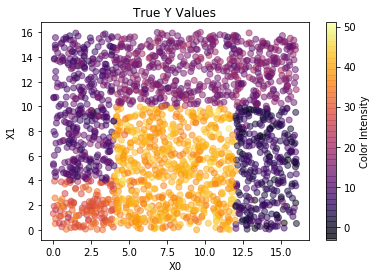

In [15]:
plt.scatter( data['X0'], data['X1'] , c=data['Y'], 
            cmap = 'inferno', alpha =0.5)
cbar = plt.colorbar()
cbar.set_label('Color Intensity')
plt.title('True Y Values')
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

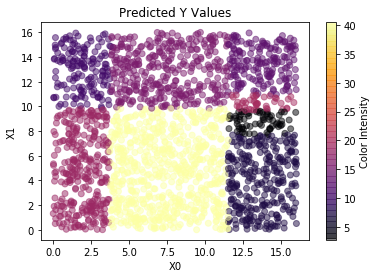

In [16]:
plt.scatter( data['X0'], data['X1'] , c=data['YPred'], 
            cmap = 'inferno', alpha =0.5)
cbar = plt.colorbar()
cbar.set_label('Color Intensity')
plt.title('Predicted Y Values')
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

## So how have we done then?

Hopefully we can see that our model has successfully captured at least some of the non-linear structure in the training set (slight differences in colour may reflect different scales on the colour bars). On my implementation the model performed slightly poorly on the values where X0 < 4, partitioning the space with an incorrect value of X1 - that is the price we must be prepared to pay for using a greedy implementation of the algorithm. However hopefully this notebook demonstrates that Decision Trees can be powerful tools for learning non-linear relationships.

# Next Step

An immediate next step would be to enable the model to be pruned after fitting. Pruning means reducing the depth of the tree in some directions and we'd like to prune the nodes which have little or no effect on performance - for example if two sibling terminal nodes tell us to predict an almost identical value for each, then we could simply convert their parent into a terminal node and assign every observation in the amalgamated space the same value.

In the real world, Decision Trees are most commonly used a building block for more complex models. Random Forests and Boosting are two examples of widely used algorithms which leverage Decision Trees to make predictions.